# Imports

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shap
from joblib import dump, load

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

## Metrics
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (auc,roc_auc_score, ConfusionMatrixDisplay, 
                             precision_score, PrecisionRecallDisplay,
                             recall_score, roc_curve,RocCurveDisplay, f1_score,
                             accuracy_score, classification_report)

# Functions

In [2]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
  ## Get the classification report
  report = classification_report(y_true, y_pred)
    
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
    
  ## Confusion matrices subplots
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
  ## Confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0]);
  axes[0].set_title("Raw Counts")
  
  ## Confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")

  ## Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  
  ## Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [3]:
def multiclass_roc_auc_score(model, X_test, y_test, num_classes):
    # Binarize the output labels
    y_binarized = label_binarize(y_test, classes=[*range(num_classes)])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_prob = model.predict_proba(X_test)
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        # Plotting each class's ROC curve (optional)
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for class {i}')
        plt.legend(loc="lower right")
        plt.show()

    # Calculate the average ROC AUC score
    average_roc_auc = np.mean(list(roc_auc.values()))
    print(f"Average ROC AUC score: {average_roc_auc}")

    return roc_auc, average_roc_auc

In [4]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, num_classes=3,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    ## Get predictions & probability for training data
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)
    
    ## Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    ## Get predictions & probability for test data
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    
    ## Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data')
    
    ## Visualize the ROC curve
    multiclass_roc_auc_score(model, X_test, y_test, num_classes)
    
    
    if output_dict == True:
        ## Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

# Load Data

In [5]:
## Load unprocessed data to avoid data leakage
df = pd.read_csv('Data/fall_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2039 entries, 0 to 2038
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Distance       2039 non-null   float64
 1   Pressure       2039 non-null   float64
 2   HRV            2039 non-null   float64
 3   Sugar level    2039 non-null   float64
 4   SpO2           2039 non-null   float64
 5   Accelerometer  2039 non-null   float64
 6   Decision       2039 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 111.6 KB


Distance  Pressure      HRV  Sugar level    SpO2  Accelerometer  Decision 
0    25.540       1.0  101.396       61.080  87.770            1.0          1
1     2.595       2.0  110.190       20.207  65.190            1.0          2
2    68.067       0.0   87.412       79.345  99.345            0.0          0
3    13.090       1.0   92.266       36.180  81.545            1.0          1
4    69.430       0.0   89.480       80.000  99.990            0.0          0

In [6]:
# Select a random subset of 700 rows
subset_indices = np.random.choice(df.index, size=2000, replace=False)
subset_df = df.loc[subset_indices]

# Add random noise to the subset columns
noise_scale = 0.1  # Adjust the scale of noise according to your preference
subset_df += np.random.normal(0, noise_scale, size=subset_df.shape)

subset_df.info()
subset_df.head()

# Round the columns that need to be whole numbers
subset_df['Pressure'] = subset_df['Pressure'] % 3
subset_df['Accelerometer'] = subset_df['Accelerometer'] % 2
subset_df['Decision '] = subset_df['Decision '] % 3
subset_df.describe()

df = pd.concat([df, subset_df], ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 195 to 528
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Distance       2000 non-null   float64
 1   Pressure       2000 non-null   float64
 2   HRV            2000 non-null   float64
 3   Sugar level    2000 non-null   float64
 4   SpO2           2000 non-null   float64
 5   Accelerometer  2000 non-null   float64
 6   Decision       2000 non-null   float64
dtypes: float64(7)
memory usage: 125.0 KB


In [7]:
## Format column headers to lowercase
df.columns = df.columns.str.lower()
df.head()

distance  pressure      hrv  sugar level    spo2  accelerometer  decision 
0    25.540       1.0  101.396       61.080  87.770            1.0        1.0
1     2.595       2.0  110.190       20.207  65.190            1.0        2.0
2    68.067       0.0   87.412       79.345  99.345            0.0        0.0
3    13.090       1.0   92.266       36.180  81.545            1.0        1.0
4    69.430       0.0   89.480       80.000  99.990            0.0        0.0

In [8]:
df.columns

Index(['distance', 'pressure', 'hrv', 'sugar level', 'spo2', 'accelerometer',
       'decision '],
      dtype='object')

In [9]:
## Reformat column names
df.rename(columns={'distance':'distance (cm)','hrv':'hrv (bpm)',
                   'sugar level':'blood sugar level (mg/dL)',
                   'decision ':'decision',}, inplace=True)
df.head()

distance (cm)  pressure  hrv (bpm)  blood sugar level (mg/dL)    spo2  \
0         25.540       1.0    101.396                     61.080  87.770   
1          2.595       2.0    110.190                     20.207  65.190   
2         68.067       0.0     87.412                     79.345  99.345   
3         13.090       1.0     92.266                     36.180  81.545   
4         69.430       0.0     89.480                     80.000  99.990   

   accelerometer  decision  
0            1.0       1.0  
1            1.0       2.0  
2            0.0       0.0  
3            1.0       1.0  
4            0.0       0.0

In [10]:
## Determine class balance in the target
df['decision'].value_counts(normalize=True)

0.000000    0.170834
1.000000    0.168854
2.000000    0.165140
2.022786    0.000248
2.971341    0.000248
              ...   
1.152689    0.000248
1.961897    0.000248
0.144106    0.000248
1.932860    0.000248
1.856810    0.000248
Name: decision, Length: 2003, dtype: float64

> The class balance is pretty evenly split so we will not need to re-balance classes. 

In [11]:
# Randomize the values in the column
df['decision'] = np.random.randint(0, 3, size=len(df))
df.head()

distance (cm)  pressure  hrv (bpm)  blood sugar level (mg/dL)    spo2  \
0         25.540       1.0    101.396                     61.080  87.770   
1          2.595       2.0    110.190                     20.207  65.190   
2         68.067       0.0     87.412                     79.345  99.345   
3         13.090       1.0     92.266                     36.180  81.545   
4         69.430       0.0     89.480                     80.000  99.990   

   accelerometer  decision  
0            1.0         1  
1            1.0         1  
2            0.0         0  
3            1.0         1  
4            0.0         1

In [12]:
## Save ML dataframe
df.to_csv('Data/ml_df.csv')

# Model Validation & Preprocessing

## Train Test Split

In [13]:
## Train test split
X = df.drop(columns=['decision'])
y = df['decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
## Print length of train and test splits
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 3029
Length of X_test: 1010


## Preprocessing Pipeline

In [15]:
## Column Transformers
scaler = StandardScaler()

## Column selectors
num_col = make_column_selector(dtype_include='number')

## Tuples for pipeline
num_tuple = (scaler, num_col)

## Preprocessor object
prepocessor = make_column_transformer(num_tuple, verbose_feature_names_out=False)
prepocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                  verbose_feature_names_out=False)

# Baseline Models

## Decision Tree

In [16]:
## Instantiate and fit random forest model
tree = DecisionTreeClassifier()
tree_pipe = make_pipeline(prepocessor, tree)

tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00       991
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3029
   macro avg       1.00      1.00      1.00      3029
weighted avg       1.00      1.00      1.00      3029



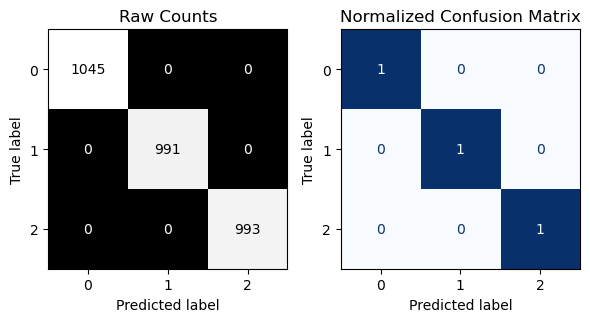


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.37      0.35       333
           1       0.31      0.28      0.30       337
           2       0.34      0.31      0.32       340

    accuracy                           0.32      1010
   macro avg       0.32      0.32      0.32      1010
weighted avg       0.32      0.32      0.32      1010



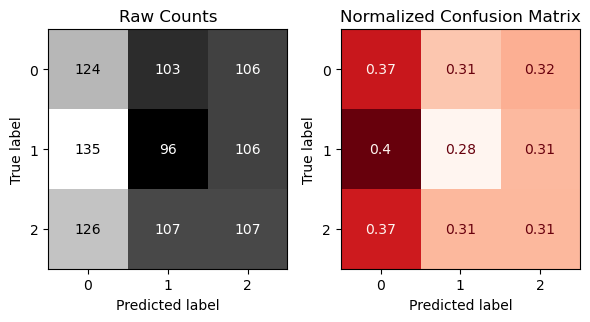

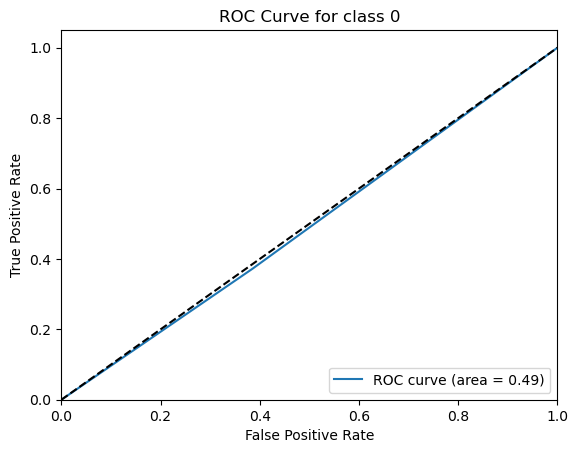

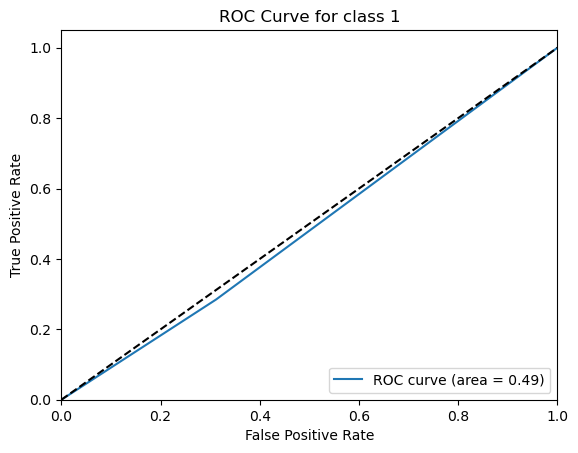

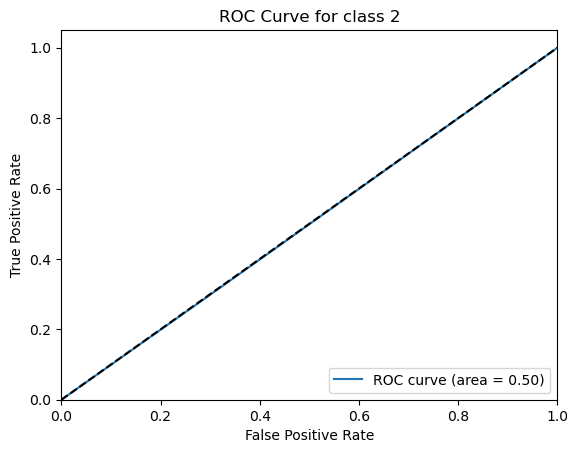

Average ROC AUC score: 0.4929944632785715


In [17]:
evaluate_classification(tree_pipe, X_train, y_train, X_test, y_test, num_classes=3,
                        figsize=(6,4), normalize='true', output_dict = False,
                        cmap_train='Blues', cmap_test="Reds",colorbar=False)

## Random Forest

In [18]:
## Instantiate and fit random forest model
rf = RandomForestClassifier()
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00       991
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3029
   macro avg       1.00      1.00      1.00      3029
weighted avg       1.00      1.00      1.00      3029



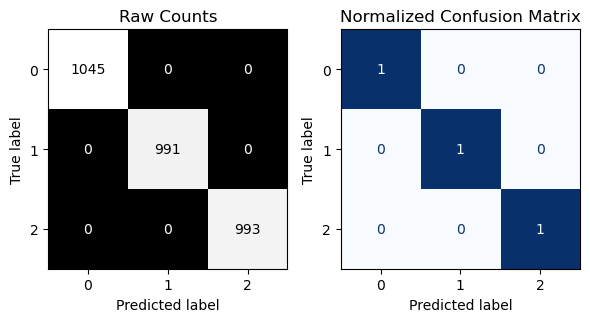


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.35      0.41      0.38       333
           1       0.37      0.36      0.37       337
           2       0.36      0.30      0.33       340

    accuracy                           0.36      1010
   macro avg       0.36      0.36      0.36      1010
weighted avg       0.36      0.36      0.36      1010



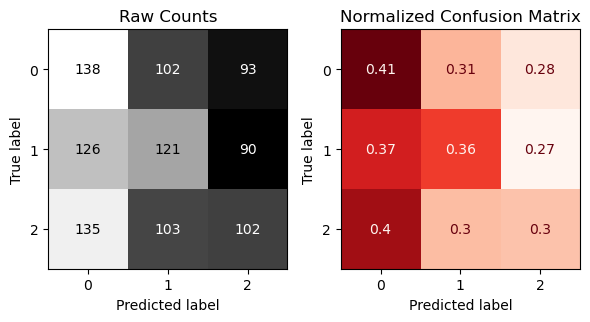

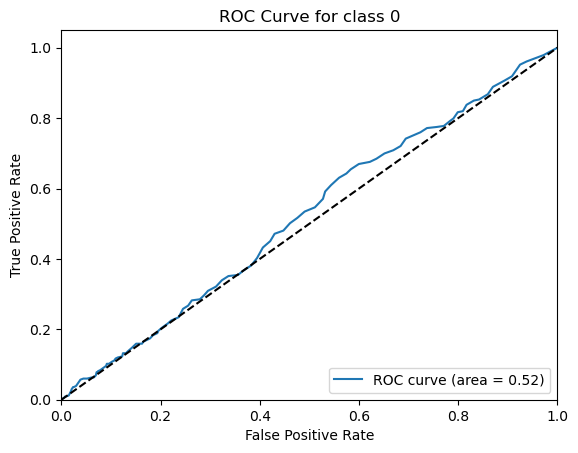

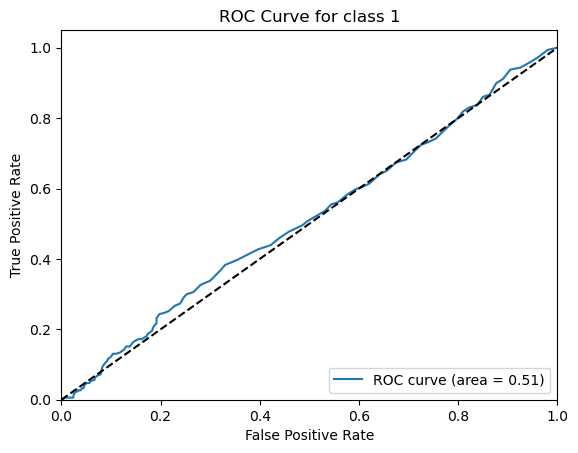

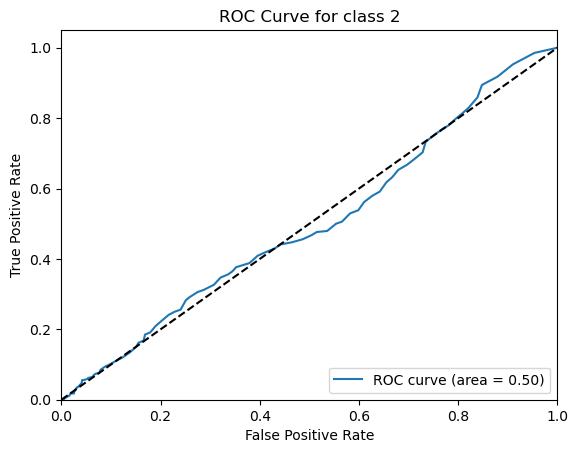

Average ROC AUC score: 0.5118859212351031


In [19]:
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

## LightGBM

In [20]:
## Instantiate and fit lightgbm model 
lgb = LGBMClassifier()
lgb_pipe = make_pipeline(prepocessor, lgb)

lgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                                   verbose_feature_names_out=False)),
                ('lgbmclassifier', LGBMClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      1045
           1       0.68      0.66      0.67       991
           2       0.70      0.65      0.68       993

    accuracy                           0.68      3029
   macro avg       0.68      0.68      0.68      3029
weighted avg       0.68      0.68      0.68      3029



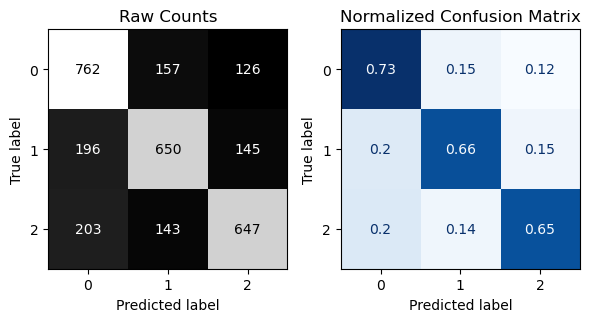


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.38      0.36       333
           1       0.35      0.35      0.35       337
           2       0.32      0.27      0.29       340

    accuracy                           0.33      1010
   macro avg       0.33      0.34      0.33      1010
weighted avg       0.33      0.33      0.33      1010



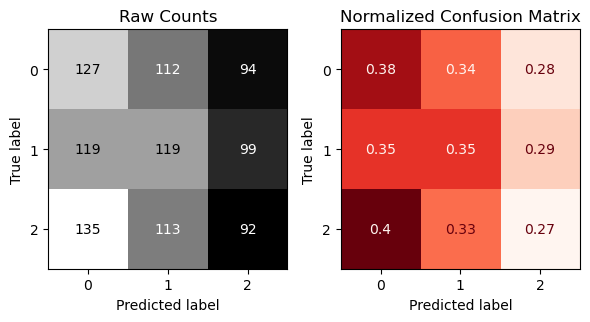

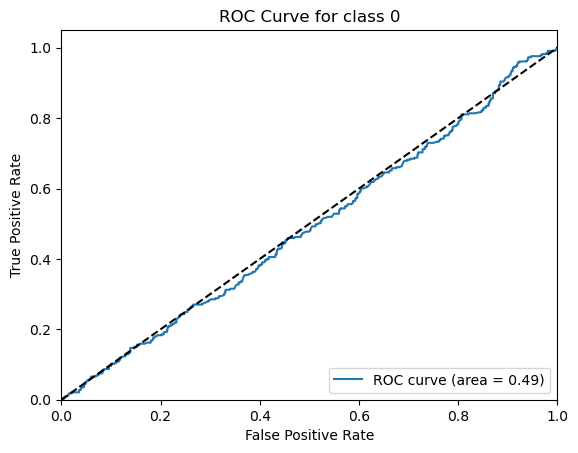

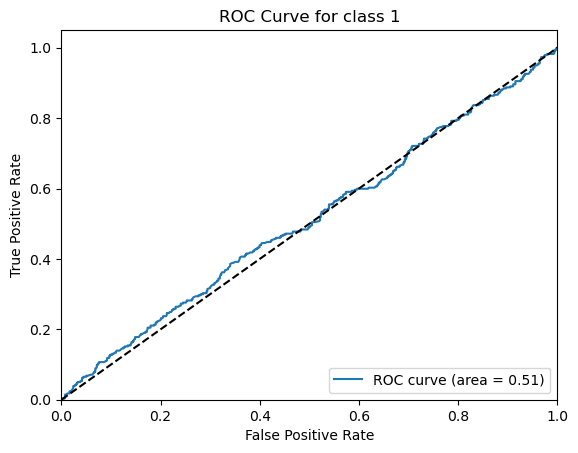

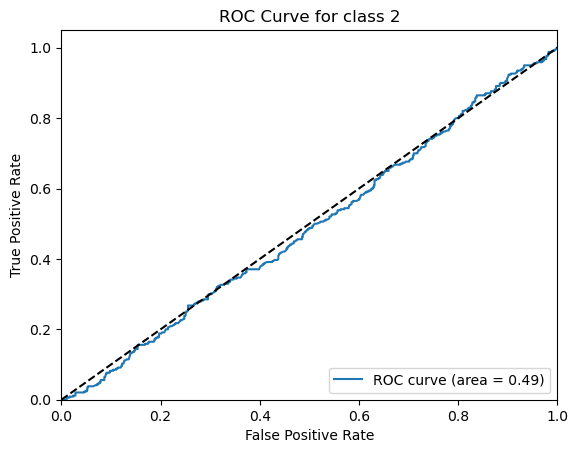

Average ROC AUC score: 0.49649923846129457


In [21]:
evaluate_classification(lgb_pipe, X_train, y_train, X_test, y_test)

# Hyperparameter Tuning with GridSearch CV

## Decision Tree

In [22]:
## Get model parameters
tree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                     verbose_feature_names_out=False)),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                   verbose_feature_names_out=False),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_colu

In [23]:
## Parameters to be tested
param_grid = {'decisiontreeclassifier__class_weight': [None, 'balanced'],
              'decisiontreeclassifier__max_depth': [None, 10, 100, 1000],
              'decisiontreeclassifier__max_leaf_nodes': [None, 10, 100, 1000]} 

In [24]:
## Fit and evaluate
tree_gs = GridSearchCV(tree_pipe, param_grid, verbose=2)
tree_gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_leaf_nodes=10; total time=   0.0s
[CV]

[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=100, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=100, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=100, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreeclassifier__max_depth=1000, decisiontreeclassifier__max_leaf_nodes=None; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=None, decisiontreecla

[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_leaf_nodes=100; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, decisiontreeclassifier__max_depth=10, decisiontreeclassifier__max_leaf_nodes=1000; total time=   0.0s
[CV] END decisiontreeclassifier__class_weight=balanced, 

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__class_weight': [None,
                                                                  'balanced'],
                         'decisiontreeclassifier__max_depth': [None, 10, 100,
                                                               1000],
                         'decisiontreeclassifier__max_leaf_nodes': [None, 10,
                                                                    100,
                                                                    1000]},
             verbose=2)

In [25]:
tree_gs.best_params_

{'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__max_depth': 100,
 'decisiontreeclassifier__max_leaf_nodes': None}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00       991
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3029
   macro avg       1.00      1.00      1.00      3029
weighted avg       1.00      1.00      1.00      3029



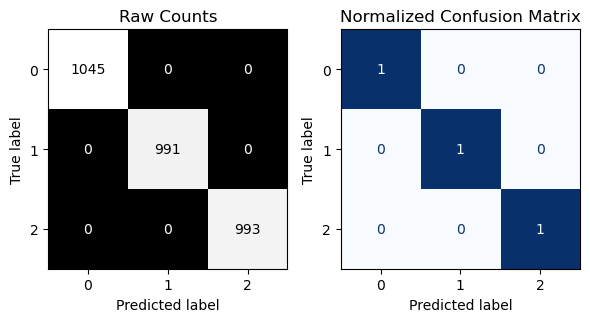


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.34      0.39      0.36       333
           1       0.33      0.32      0.33       337
           2       0.34      0.30      0.32       340

    accuracy                           0.33      1010
   macro avg       0.33      0.33      0.33      1010
weighted avg       0.33      0.33      0.33      1010



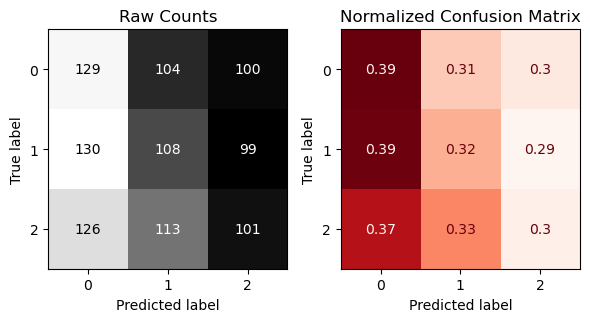

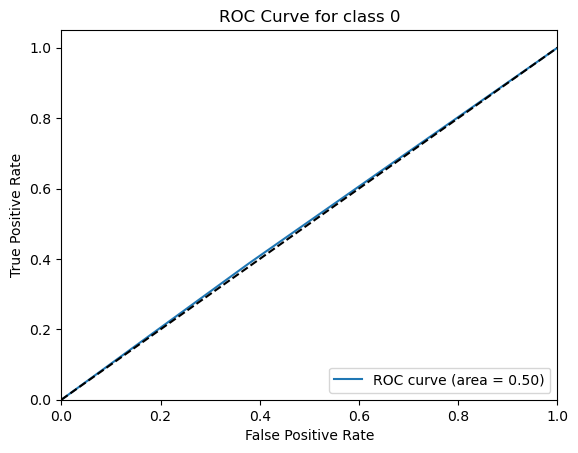

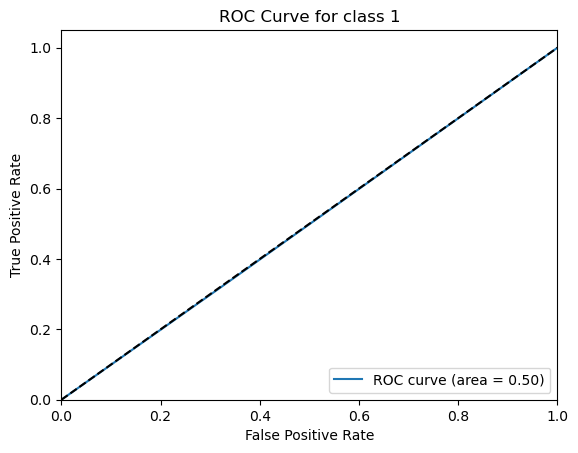

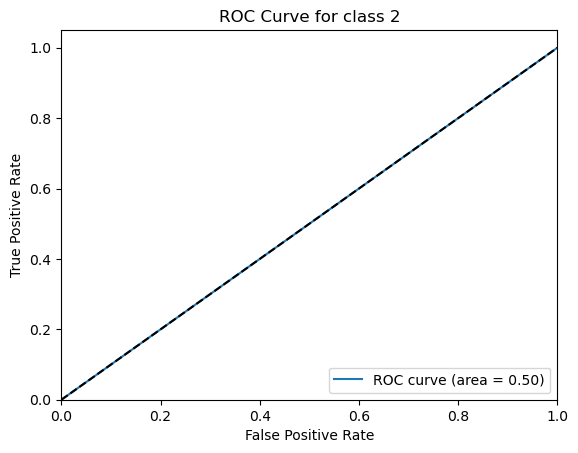

Average ROC AUC score: 0.5012217275346388


In [26]:
## Fit best estimator
best_tree_gs = tree_gs.best_estimator_
best_tree_gs.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(best_tree_gs, X_train, y_train, X_test, y_test)

## Random Forest

In [27]:
## Get model parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                   verbose_feature_names_out=False),
 'randomforestclassifier': RandomForestClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transformer_weights': None,
 'columntransformer__transformers': [('standardscaler',
   StandardScaler(),
   <sklearn.compose._column_transformer.make_colu

In [28]:
## Parameters to be tested
param_grid = {'randomforestclassifier__class_weight': ['balanced'],
              'randomforestclassifier__max_depth': [10, 100, 1000],
              'randomforestclassifier__max_leaf_nodes': [10, 100, 1000],
              'randomforestclassifier__n_estimators': [10, 100]} 

In [29]:
## Fit and evaluate
rf_gs = GridSearchCV(rf_pipe, param_grid, verbose=2)
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestclassifier__n_estimators=10; total time=   0.0s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=10, randomforestclassifier__max_leaf_nodes=10, randomforestcl

[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.2s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=100, randomforestclassifier__max_leaf_nodes=100, randomforestclassifier__n_estimators=100; total time=   0.2s


[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.3s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.3s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.3s
[CV] END randomforestclassifier__class_weight=balanced, randomforestclassifier__max_depth=1000, randomforestclassifier__max_leaf_nodes=1000, randomforestclassifier__n_estimators=100; total time=   0.3s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001454ED5BE20>)],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__class_weight': ['balanced'],
                         'randomforestclassifier__max_depth': [10, 100, 1000],
                         'randomforestclassifier__max_leaf_nodes': [10, 100,
                                                                    1000],
                         'randomforestclassifier__n_estimators': [10, 100]},
             verbose=2)

In [30]:
rf_gs.best_params_

{'randomforestclassifier__class_weight': 'balanced',
 'randomforestclassifier__max_depth': 100,
 'randomforestclassifier__max_leaf_nodes': 1000,
 'randomforestclassifier__n_estimators': 10}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1045
           1       0.96      0.96      0.96       991
           2       0.95      0.95      0.95       993

    accuracy                           0.96      3029
   macro avg       0.96      0.96      0.96      3029
weighted avg       0.96      0.96      0.96      3029



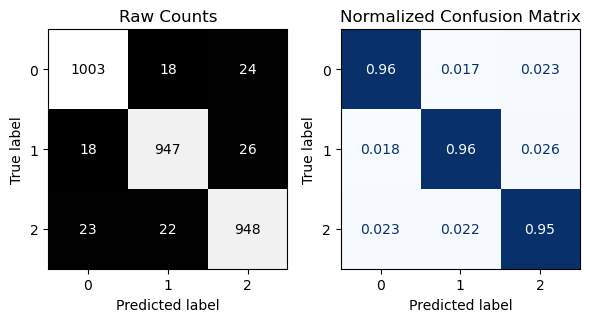


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.39      0.36       333
           1       0.35      0.38      0.36       337
           2       0.35      0.26      0.29       340

    accuracy                           0.34      1010
   macro avg       0.34      0.34      0.34      1010
weighted avg       0.34      0.34      0.34      1010



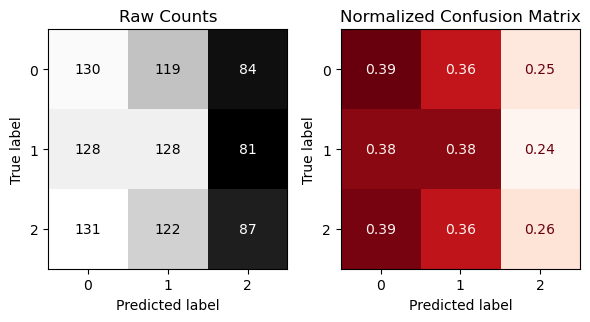

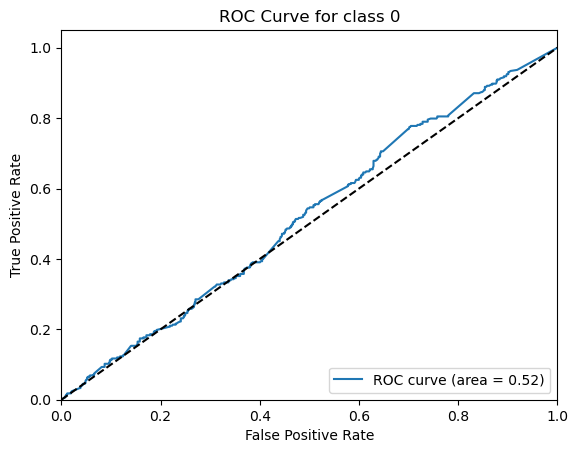

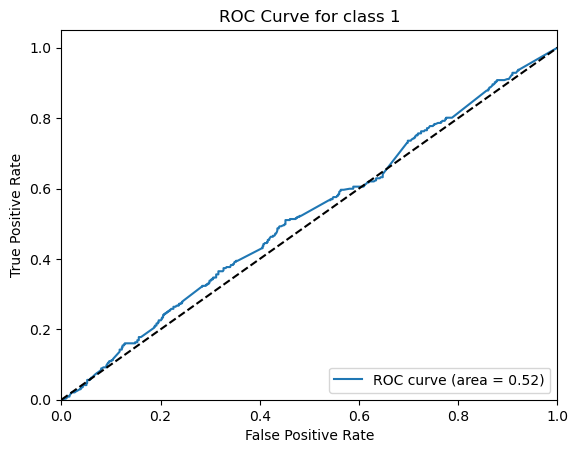

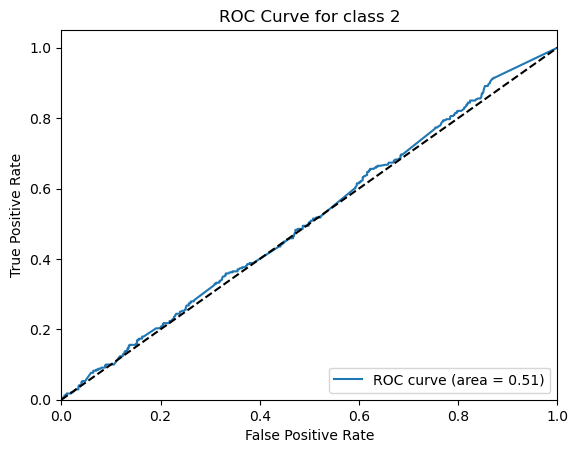

Average ROC AUC score: 0.5183031839166558


In [31]:
## Fit best estimator
best_rf_gs = rf_gs.best_estimator_
best_rf_gs.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(best_rf_gs, X_train, y_train, X_test, y_test)

In [32]:
best_rf_gs

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014551C5B2B0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=100,
                                        max_leaf_nodes=1000,
                                        n_estimators=10))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00       991
           2       1.00      1.00      1.00       993

    accuracy                           1.00      3029
   macro avg       1.00      1.00      1.00      3029
weighted avg       1.00      1.00      1.00      3029



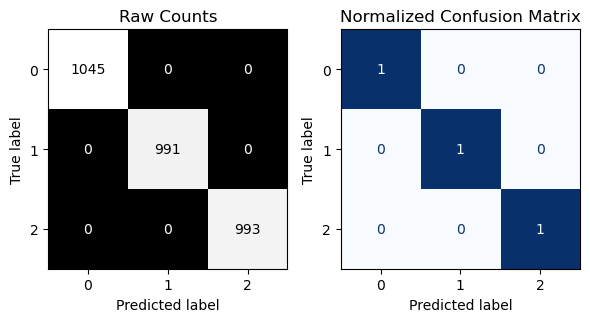


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.35      0.42      0.38       333
           1       0.34      0.33      0.34       337
           2       0.34      0.28      0.30       340

    accuracy                           0.34      1010
   macro avg       0.34      0.34      0.34      1010
weighted avg       0.34      0.34      0.34      1010



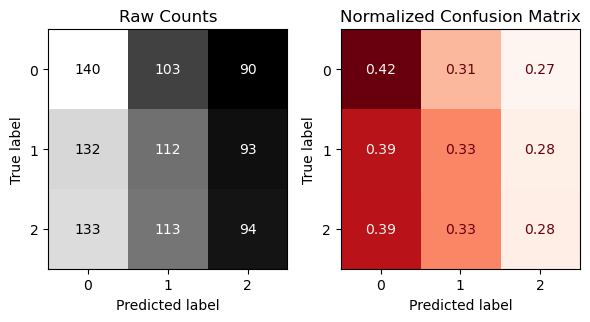

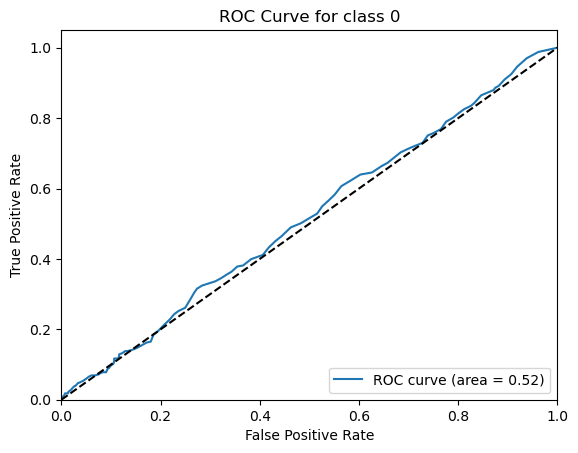

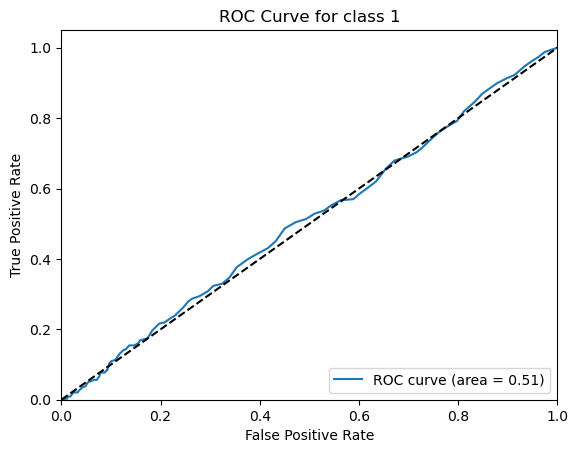

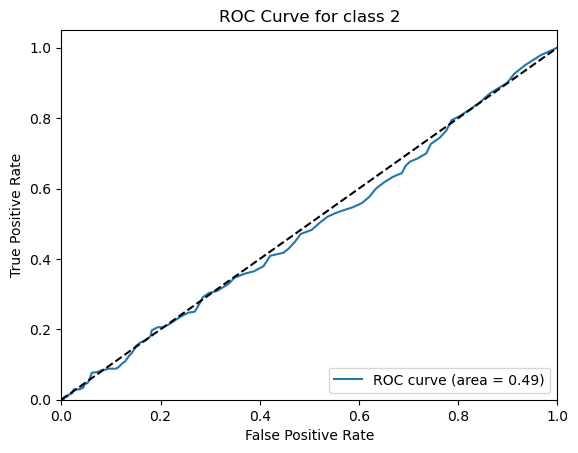

Average ROC AUC score: 0.5042143980202619


In [33]:
## Instantiate and fit random forest model
rf = RandomForestClassifier(class_weight='balanced', max_depth=100, n_estimators=100)
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

## Evaluate tuned model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

# Final Model Explanation

In [34]:
# Access the RandomForestClassifier from the pipeline
rf_classifier = best_rf_gs.named_steps['randomforestclassifier']

# Extract feature importances
feature_names = rf_pipe[:-1].get_feature_names_out()  # Getting feature names correctly from the pipeline
feature_importance = pd.Series(rf_classifier.feature_importances_, index=feature_names)

# Create a DataFrame from the series for easier handling with Plotly
feature_importance_df = pd.DataFrame({'Feature': feature_importance.index, 'Importance': feature_importance.values})

# Sort the DataFrame by importance
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Visualize using Plotly Express - showing all features or just top 4 if needed
fig = px.bar(sorted_feature_importance_df, x='Importance', y='Feature', orientation='h', 
             title='Average Feature Importances')
fig.update_layout(xaxis_title='Feature Importance Value', yaxis_title='Feature Name')

# Show the plot
fig.show()

In [35]:
feature_names = X_train.columns

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_df)

# Since we have 3 classes, shap_values will be a list of 3 arrays: one for each class
for i in range(3):  # Assuming three classes
    shap_df = pd.DataFrame(shap_values[i], columns=feature_names)
    
    # Summarize SHAP values per feature (mean absolute value for simplicity)
    shap_summary = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Value (mean abs)': shap_df.abs().mean().values
    })
    
    # Sort the DataFrame by SHAP values in descending order
    shap_summary_sorted = shap_summary.sort_values(by='SHAP Value (mean abs)', ascending=True)
    
    # Plot using Plotly Express
    fig = px.bar(shap_summary_sorted, x='SHAP Value (mean abs)', y='Feature',
                 orientation='h', title=f"Mean Absolute SHAP Values for Class {i}",
                 labels={'SHAP Value (mean abs)': 'Mean Absolute SHAP Value'},
                 color='SHAP Value (mean abs)',
                 color_continuous_scale=px.colors.diverging.Tealrose,
                 template='plotly_white')

    fig.show()

In [36]:
feature_names = X_train.columns

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_df)

if isinstance(shap_values, list):
    shap_values_for_class = shap_values[2]  # Adjust the index if a different class is of interest
else:
    shap_values_for_class = shap_values

# Get the SHAP values for the first prediction
shap_values_first_prediction = shap_values_for_class[0]

# Find the index of the feature with the highest absolute SHAP value
most_important_feature_index = np.argmax(np.abs(shap_values_first_prediction))

# Get the name of the most important feature
most_important_feature_name = feature_names[most_important_feature_index]

# Optionally, you can print or return this information
print(f"The most important feature for the first prediction is {most_important_feature_name} with a SHAP value of {shap_values_first_prediction[most_important_feature_index]}")


The most important feature for the first prediction is blood sugar level (mg/dL) with a SHAP value of 0.07207006004222236


In [37]:
# Feature names extracted from the training set
feature_names = X_train.columns

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Access the RandomForestClassifier from the pipeline
rf_classifier = rf_pipe.named_steps['randomforestclassifier']

# Transform the test set
X_test_df = pd.DataFrame(rf_pipe[:-1].transform(X_test),
                         columns=feature_names,
                         index=X_test.index)

# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(X_test_df)

# Choose an instance to analyze
instance_index = 0  # Change as needed

# Determine the most important feature for each class
important_features = {}
for class_index in range(3):  # Assuming there are 3 classes
    class_shap_values = shap_values[class_index][instance_index]
    most_important_feature_index = np.argmax(np.abs(class_shap_values))
    most_important_feature = X_test.columns[most_important_feature_index]
    important_features[f'Class {class_index}'] = most_important_feature

print("Most important features for each class:")
for class_label, feature in important_features.items():
    print(f"{class_label}: {feature}")


Most important features for each class:
Class 0: pressure
Class 1: distance (cm)
Class 2: pressure


In [38]:
best_rf_gs

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014551C5B2B0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=100,
                                        max_leaf_nodes=1000,
                                        n_estimators=10))])

In [39]:
## Saving model pipeline to joblib file
dump(best_rf_gs, 'rf.joblib')

['rf.joblib']

In [40]:
## Confirm model saved correctly
model= load('rf.joblib')

In [41]:
def predict_label(features_df):
    
    ## Load saved model
    model = load('rf.joblib')

    # Make a prediction with the trained model
    prediction_label = model.predict(features_df)
    
    
    # Return prediction labels and confidence scores
    return prediction_label

In [42]:
predict_label(df)

array([0, 1, 2, ..., 0, 2, 1])

In [43]:
for name, step in model.named_steps.items():
    print(f"Step name: {name} - Estimator type: {type(step).__name__}")

Step name: columntransformer - Estimator type: ColumnTransformer
Step name: randomforestclassifier - Estimator type: RandomForestClassifier


In [44]:
print(model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014551F4B2B0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=100,
                                        max_leaf_nodes=1000,
                                        n_estimators=10))])
